# Paleopandas Playground

The goal of this notebook is to explore the uses of pandas within Pyleoclim, particularly since the implementation of non-nanosecond time resolutions that allow for geological and cosmological time scales to be represented within NumPy/Pandas (references needed)

In [3]:
%load_ext autoreload
%load_ext watermark
%autoreload 2

import pandas as pd
import pyleoclim as pyleo
import datetime
import numpy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


## Series creation:

A new feature is that Pyleoclim ships with a few pre-defined datasets

In [4]:
pyleo.utils.available_dataset_names()

['SOI', 'NINO3', 'HadCRUT5', 'AIR', 'LR04', 'AACO2', 'GISP2', 'nino_json']

Time axis values sorted in ascending order


(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: xlabel='time [year C.E.]', ylabel='SOI [mb]'>)

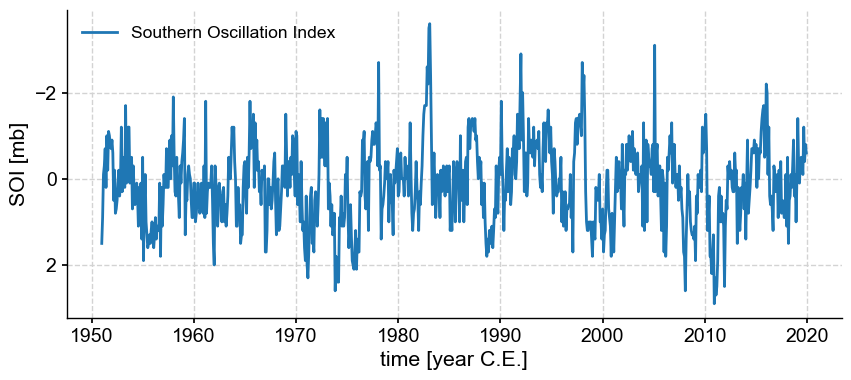

In [5]:
ts = pyleo.utils.load_dataset('SOI')
ts.plot(invert_yaxis=True)

New properties attached to `pyleo.Series` objects:
1. a pandas datetime_index:

In [6]:
ts.datetime_index

DatetimeIndex(['1950-12-31 12:42:56', '1951-01-30 23:11:49',
               '1951-03-02 09:41:14', '1951-04-01 20:10:07',
               '1951-05-02 06:39:01', '1951-06-01 17:08:26',
               '1951-07-02 03:37:19', '1951-08-01 14:06:12',
               '1951-09-01 00:35:37', '1951-10-01 11:04:30',
               ...
               '2019-03-01 20:57:20', '2019-04-01 07:26:14',
               '2019-05-01 17:55:07', '2019-06-01 04:24:32',
               '2019-07-01 14:53:25', '2019-08-01 01:22:19',
               '2019-08-31 11:51:43', '2019-09-30 22:20:37',
               '2019-10-31 08:49:30', '2019-11-30 19:18:55'],
              dtype='datetime64[s]', name='datetime', length=828, freq=None)

2. a dictionary bundling all the metadata:

In [7]:
ts.metadata

{'time_unit': 'year C.E.',
 'time_name': 'time',
 'value_unit': 'mb',
 'value_name': 'SOI',
 'label': 'Southern Oscillation Index',
 'lat': None,
 'lon': None,
 'archiveType': 'Instrumental',
 'importedFrom': None,
 'log': ({0: 'dropna', 'applied': True, 'verbose': True},
  {1: 'sort_ts', 'direction': 'ascending'})}

When invoking the object itself, the `__repr__` method is called, showing some essential metadata and a compressed view of the data:   

In [8]:
ts

{'archiveType': 'Instrumental',
 'label': 'Southern Oscillation Index',
 'log': ({0: 'dropna', 'applied': True, 'verbose': True},
         {1: 'sort_ts', 'direction': 'ascending'})}


None
time [year C.E.]
1951.000000    1.5
1951.083333    0.9
1951.166667   -0.1
1951.250000   -0.3
1951.333333   -0.7
              ... 
2019.583333   -0.1
2019.666667   -1.2
2019.750000   -0.4
2019.833333   -0.8
2019.916667   -0.6
Name: SOI [mb], Length: 828, dtype: float64

For a prettier display (in Jupyter notebook only):

In [9]:
ts.view()

,SOI [mb]
time [year C.E.],
1951.000000,1.5
1951.083333,0.9
1951.166667,-0.1
1951.250000,-0.3
1951.333333,-0.7
...,...
2019.583333,-0.1
2019.666667,-1.2
2019.750000,-0.4


## to_pandas()

one can export from pyleo.Series to a pandas Series:

In [10]:
pdts = ts.to_pandas() #  returns just the Series ; metadata are available at ts.metadata
type(pdts) 

pandas.core.series.Series

It is now a bona fide Pandas series, and we can do with it everything we might do with pandas, like:

In [11]:
pdts.head()

datetime
1950-12-31 12:42:56    1.5
1951-01-30 23:11:49    0.9
1951-03-02 09:41:14   -0.1
1951-04-01 20:10:07   -0.3
1951-05-02 06:39:01   -0.7
Name: SOI, dtype: float64

Or this:

In [13]:
pdts.describe()

count    828.000000
mean       0.119928
std        0.938586
min       -3.600000
25%       -0.500000
50%        0.100000
75%        0.800000
max        2.900000
Name: SOI, dtype: float64

Because Pyleoclim now has pandas under the hood, there is now a way to apply any pandas method to a pyleoclim Series, via a [lambda function](https://www.freecodecamp.org/news/python-lambda-function-explained/). For instance:

<AxesSubplot: xlabel='time [year C.E.]', ylabel='SOI [mb]'>

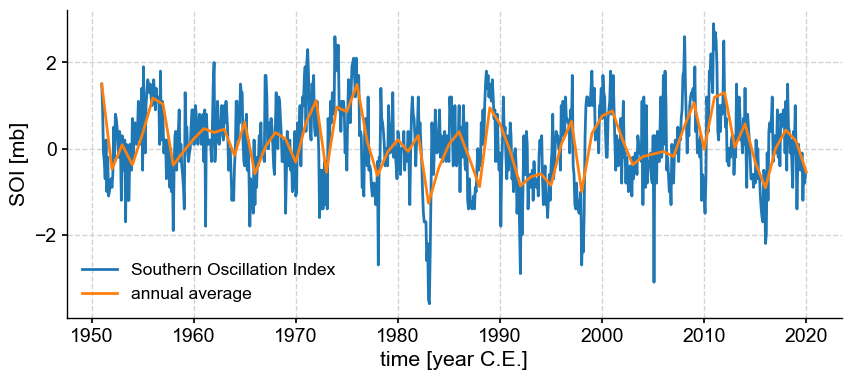

In [41]:
ts10 = ts.pandas_method(lambda x: x.resample('1Y').mean())
ts10.label = 'annual average'
fig, ax = ts.plot()
ts10.plot(ax=ax)

## Unit conversions

This new version of Pyleoclim also features enhanced coversions betwen time representations:

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: xlabel='Age [yrs BP]', ylabel='SOI [mb]'>)

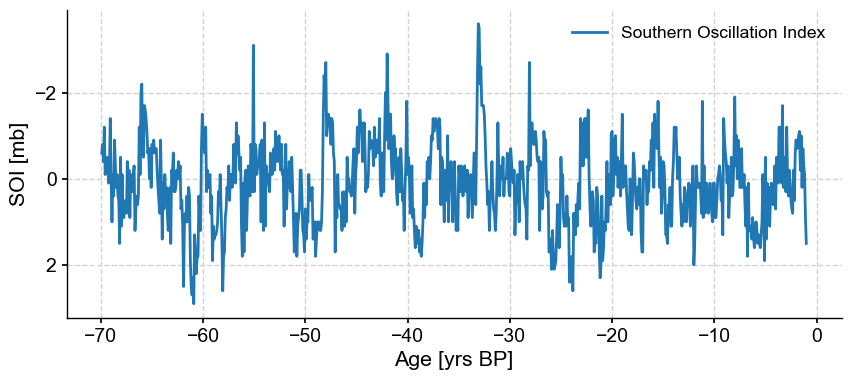

In [10]:
tsBP = ts.convert_time_unit('yrs BP')  # Not quite right
tsBP.plot(invert_yaxis=True) # by default, plots represent values in increasing order, so we reverse the x-axis

In [11]:
tsBP.datetime_index

DatetimeIndex(['2019-12-01 19:30:09', '2019-11-01 08:59:49',
               '2019-10-01 22:30:00', '2019-09-01 12:00:09',
               '2019-08-02 01:29:49', '2019-07-02 15:00:00',
               '2019-06-02 04:30:09', '2019-05-02 17:59:49',
               '2019-04-02 07:30:00', '2019-03-02 21:00:09',
               ...
               '1951-10-01 22:30:00', '1951-09-01 12:00:10',
               '1951-08-02 01:29:49', '1951-07-02 15:00:00',
               '1951-06-02 04:30:10', '1951-05-02 17:59:48',
               '1951-04-02 07:30:00', '1951-03-02 21:00:09',
               '1951-01-31 10:29:48', '1951-01-01 00:00:00'],
              dtype='datetime64[s]', name='datetime', length=828, freq=None)

Notice how the datetime index is unchanged by the time unit conversion: no matter what the units, the timestamps are fixed and absolute. `ts.time` is the only thing that does change, and is used for display purposes, including here:

In [12]:
tsBP

{'label': 'Southern Oscillation Index',
 'log': ({0: 'clean_ts', 'applied': True, 'verbose': False},)}


None
Age [yrs BP]
-69.916667   -0.6
-69.833333   -0.8
-69.750000   -0.4
-69.666667   -1.2
-69.583333   -0.1
             ... 
-1.333333    -0.7
-1.250000    -0.3
-1.166667    -0.1
-1.083333     0.9
-1.000000     1.5
Name: SOI [mb], Length: 828, dtype: float64

## Irregularly sampled series

Let us make sure that pandas' abilities are not thrown off by irregular spacing

In [15]:
path = 'ftp://ftp.ncdc.noaa.gov/pub/data/paleo/icecore/antarctica/antarctica2015co2composite.txt'
co2df = pd.read_csv(path, skiprows=137, sep='\t')
co2df.head()

,age_gas_calBP,co2_ppm,co2_1s_ppm
0,-51.03,368.02,0.06
1,-48.00,361.78,0.37
2,-46.28,359.65,0.10
3,-44.41,357.11,0.16
4,-43.08,353.95,0.04


Time axis values sorted in ascending order


(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: xlabel='Age [ky BP]', ylabel='$CO_2$ [ppm]'>)

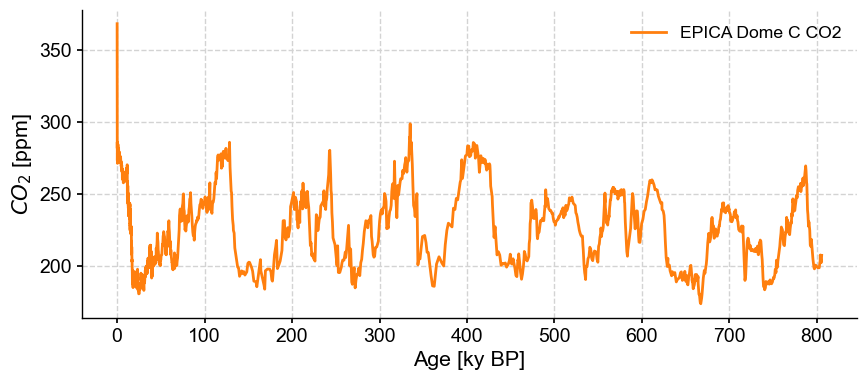

In [31]:
co2ts = pyleo.utils.load_dataset('AACO2')
co2ts.plot(color='C1')

In [16]:
co2ts.view()

,$CO_2$ [ppm]
Age [ky BP],
-0.05103,368.02
-0.04800,361.78
-0.04628,359.65
-0.04441,357.11
-0.04308,353.95
...,...
803.92528,202.92
804.00987,207.50
804.52267,204.86


To select a particular interval, (say the [Eemian](https://en.wikipedia.org/wiki/Eemian), 115 to 130 ky BP), you can use `sel`:

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: xlabel='Age [ky BP]', ylabel='$CO_2$ [ppm]'>)

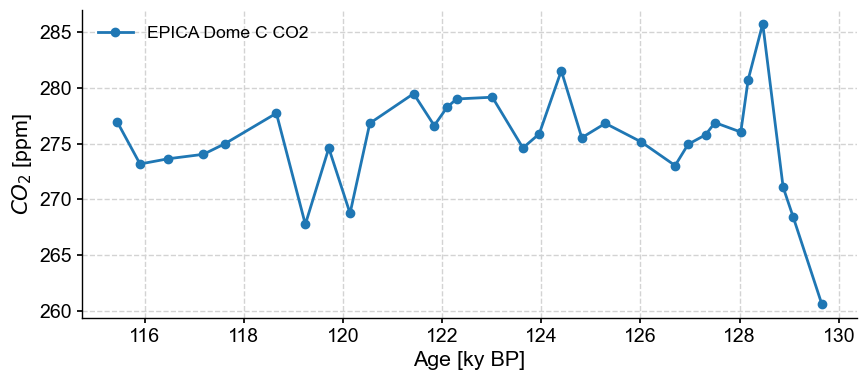

In [18]:
co2ts.sel(time=slice(115,130)).plot(marker='o')

If you wanted to extract the time of the maximum value around 286ppm:

In [26]:
x = pdts
x[x.idxmax()]

2.9

In [22]:
ts.pandas_method(lambda x : x[x.idxmax()])

ValueError: Given method does not return a pandas Series and cannot be applied

## CSV Import/Export

### to CSV

In [32]:
co2ts.to_csv()

Series exported to ./EPICA_Dome_C_CO2.csv


### from CSV
One should be able to read the file back in and get the same result:

In [34]:
co2ts2 = pyleo.Series.from_csv(filename='EPICA_Dome_C_CO2.csv')
co2ts2.equals(co2ts) # showcasing the use of the 'equals' method

Time axis values sorted in ascending order


(True, True)

## Resampling

Let's use [resample()](https://pandas.pydata.org/docs/reference/resampling.html) to coarse-grain

In [38]:
co2_5k = co2ts.resample('5ka')
type(co2_5k)

pyleoclim.core.series.SeriesResampler

The output of this function is a variant on a pandas resampler; the values then need to be aggregated or transformed. Let's average them over those 5y bins:

<AxesSubplot: xlabel='Age [ky BP]', ylabel='$CO_2$ [ppm]'>

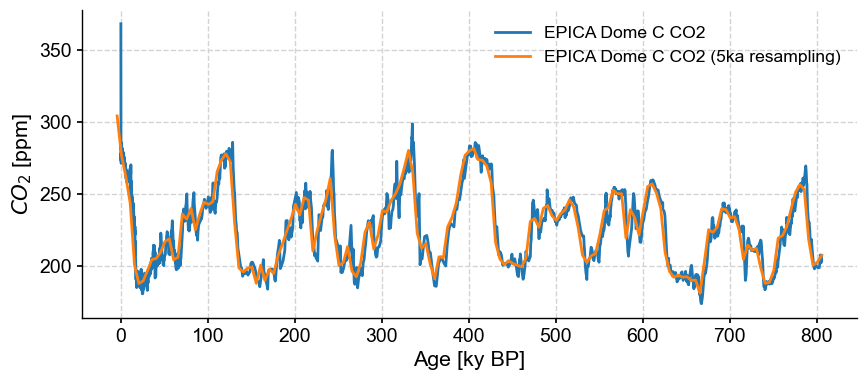

In [39]:
co2_5kavg = co2_5k.mean()
fig, ax = co2ts.plot()
co2_5kavg.plot(ax=ax,color='C1')         

Though we could choose other statistics, like a running standard deviation:

In [43]:
co2_5k.std().view()

,$CO_2$ [ppm]
Age [ky BP],
805.668666,NaN
800.668660,3.167002
795.668658,2.977565
790.668652,8.006723
785.668649,15.221735
...,...
15.668014,13.381836
10.668009,12.374541
5.668006,2.471905


<AxesSubplot: xlabel='time [year C.E.]', ylabel='SOI [mb]'>

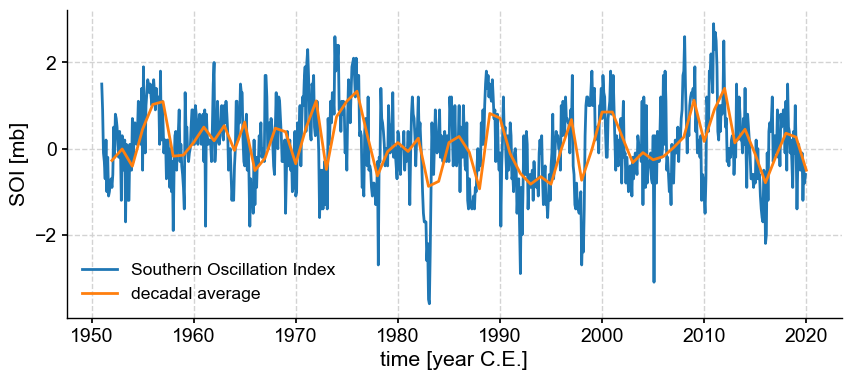

Provided time medata translated to retrograde flow, 10^0 year units, and year 1950 datum
Provided time medata translated to retrograde flow, 10^0 year units, and year 1950 datum


<AxesSubplot: xlabel='Age [yrs BP]', ylabel='SOI [mb]'>

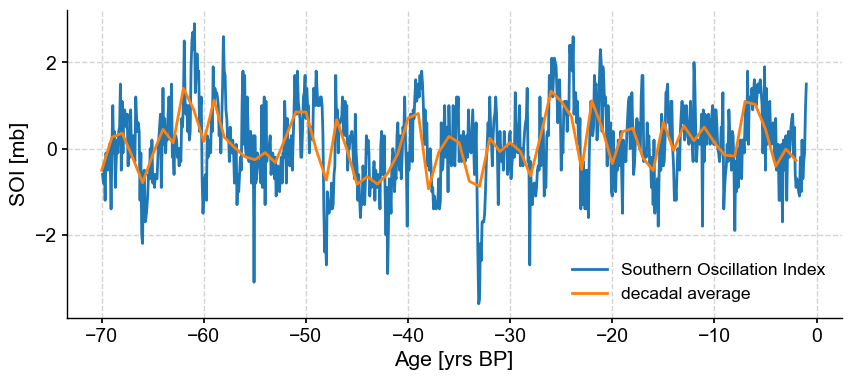

In [26]:
ts10 = tsBP.pandas_method(lambda x: x.resample('Y').mean())
ts10.label = 'decadal average'
fig, ax = tsBP.plot()
ts10.plot(ax=ax)

## Creating and manipulating multiple series

First, let's load another dataset with a time axis that has some overlap with the EPICA DOME C $CO_2$ record:

In [57]:
lr04 = pyleo.utils.load_dataset('LR04')
gisp2 = pyleo.utils.load_dataset('GISP2')

We then create a `MultipleSeries` object from them as usual:

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: xlabel='Age [yr BP]', ylabel='$\\delta^{18}$O [‰]'>)

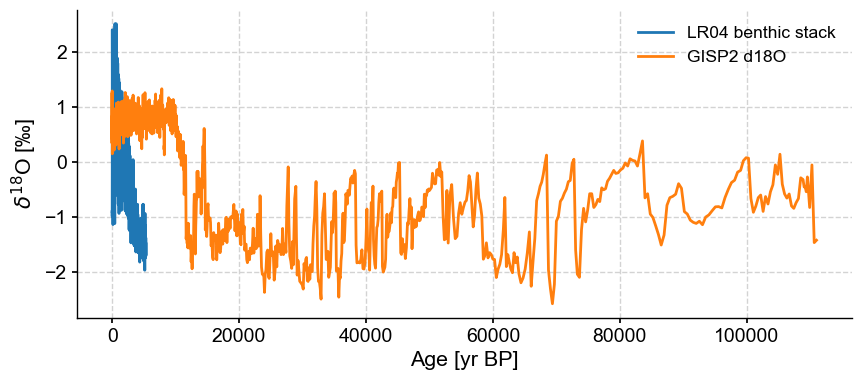

In [67]:
ms = pyleo.MultipleSeries([lr04, gisp2])
ms.standardize().plot()  # BUG: issue with the units

### Adding a series to a MultipleSeries object:

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot: xlabel='Age [ky BP]', ylabel='value'>)

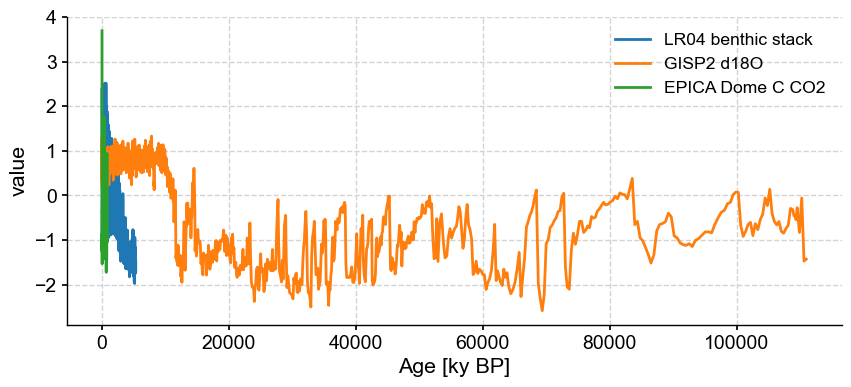

In [64]:
ms3 = ms + co2ts 
ms3.standardize().plot()

In [66]:
units = [ts.time_unit for ts in ms3.series_list]
print(units)  # maybe create a labels() function for that?

['ky BP', 'yr BP', 'ky BP']


### Adding two MultipleSeries objects together:

### Removing a series from a MultipleSeries object:

In [55]:
%watermark -n -u -v -iv -w

Last updated: Wed Feb 22 2023

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.7.0

pyleoclim : 1.0.0b0
matplotlib: 3.6.2
pandas    : 2.0.0.dev0+1541.gf3d4113052
numpy     : 1.23.5

Watermark: 2.3.1

